<a href="https://colab.research.google.com/github/bmijangos/ProyectoIntegrador/blob/main/Avance5_Equipo21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Tecnológico de Monterrey**

# **Proyecto Integrador**
## Avance 5
## Modelo Final
###Dra. Grettel Barceló Alonso
###EQUIPO 21
###Bernardo Mijango Flores - A01793654
###Dalia Isabel López Tapia - A01245026
###David Valles Canedo - A01191310
2 de junio de 2024

# Importaciones, Funciones, Dependencias y Pasos Iniciales

In [1]:
# conectamos al drive de google para la lectura de los archivos csv
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns   # para un mejor despliegue de los gráficos

from sklearn.model_selection import train_test_split

# Lectura de los datos

Se realizo una corrección en la consulta de la base de datos para obtener la edad del cliente al momento del desembolso del crédito, en el avance 1 nos dimos cuenta de este error, además se agregaron los castigos en el mismo archivo dando un total de 4,382,214 registros resultado de los 4,254,537 del archivo de pagos mas 127,677 del archivo de castigos

In [3]:
# Lectura de los archivos csv
file_path = '/content/drive/MyDrive/DataSetProyecto/GrupalTodoCorregido.csv'

label = ["IdCliente","FechaAltaCliente","CodigoGrupo","EdadCliente","Genero","EstadoCivil","Escolaridad","CapacidadPago","Localidad","CodigoSucursal","CodigoASesor","NumeroCredito","CicloCliente","FechaDesembolso","FechaVencimiento","FechaCancelacion","Plazo","PeriodoPago","EstatusCredito","MontoCredito","CuotaNumero","CuotaFechaVencimiento","CuotaFechaCancelacion","MontoCuota","MontoCapital","SaldoCapital","EstatusCuota","DiasAtraso"]

# Obtenemos el dataframe
grupal_df = pd.read_csv(file_path, names=label)

grupal_df.shape

(4382214, 28)

Text(0.5, 1.0, 'Proporcion de datos faltantes por variable')

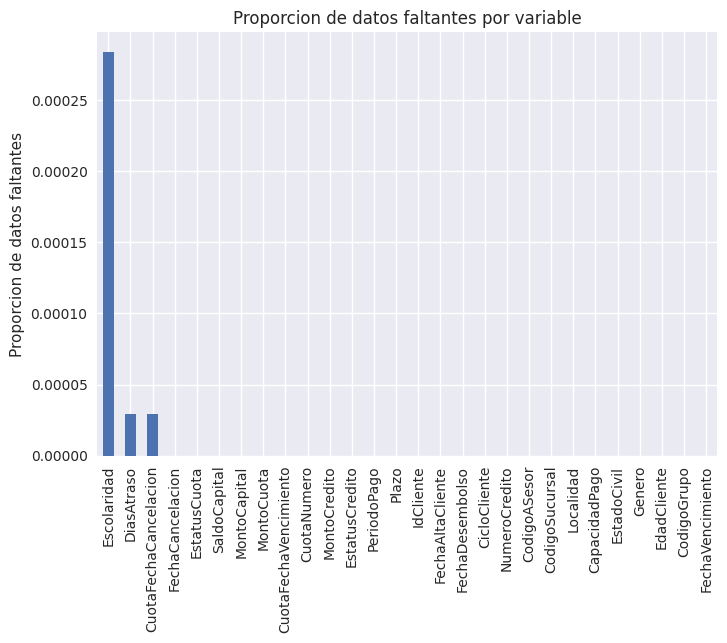

In [ ]:
# visualizamos la proporcion de los datos faltantes

with plt.style.context("seaborn"):
  grupal_df.isnull().mean().sort_values(ascending=False).plot.bar(rot=90)

plt.ylabel("Proporcion de datos faltantes")
plt.title("Proporcion de datos faltantes por variable")


Al ser un procentaje menor al 0.028 % se decide eliminarlos de la muestra

In [4]:
# eliminamos los valores nulos
gpdf = grupal_df.dropna()

In [5]:
gpdf.isnull().values.any()

False

In [6]:
# Reemplazamos los valores negativos de la variable DiasAtraso por 0 ya que son pagos anticipados
gpdf.loc[gpdf['DiasAtraso'] < 1,'DiasAtraso'] = 0


In [7]:
gpdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4380844 entries, 0 to 4382213
Data columns (total 28 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   IdCliente              int64  
 1   FechaAltaCliente       object 
 2   CodigoGrupo            int64  
 3   EdadCliente            int64  
 4   Genero                 object 
 5   EstadoCivil            int64  
 6   Escolaridad            object 
 7   CapacidadPago          float64
 8   Localidad              int64  
 9   CodigoSucursal         int64  
 10  CodigoASesor           object 
 11  NumeroCredito          int64  
 12  CicloCliente           int64  
 13  FechaDesembolso        object 
 14  FechaVencimiento       object 
 15  FechaCancelacion       object 
 16  Plazo                  int64  
 17  PeriodoPago            object 
 18  EstatusCredito         object 
 19  MontoCredito           float64
 20  CuotaNumero            int64  
 21  CuotaFechaVencimiento  object 
 22  CuotaFechaCancelacion  

### Se agregan los valores Maximos de dias de atraso por credito, la cuota del maximo dia de atraso y el porcentaje de credito pagado.

In [8]:
# obtenemos el Maximo Dias de Atraso y las siguientes variables numericas
gpmdadf = gpdf.groupby(['IdCliente','EdadCliente','NumeroCredito','PeriodoPago','CicloCliente','Plazo','EstadoCivil','EstatusCredito'])['DiasAtraso'].max().reset_index()

# renombramos la columna de la media
gpmdadf.rename(columns={'DiasAtraso':'DAMax'}, inplace=True)

gpmdadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   IdCliente       380284 non-null  int64  
 1   EdadCliente     380284 non-null  int64  
 2   NumeroCredito   380284 non-null  int64  
 3   PeriodoPago     380284 non-null  object 
 4   CicloCliente    380284 non-null  int64  
 5   Plazo           380284 non-null  int64  
 6   EstadoCivil     380284 non-null  int64  
 7   EstatusCredito  380284 non-null  object 
 8   DAMax           380284 non-null  float64
dtypes: float64(1), int64(6), object(2)
memory usage: 26.1+ MB


Se obtiene la media y la mediana de los dias de atraso por credito y por cliente

In [9]:
# obtenemos media de los Dias de Atraso por credito
gpmeandf = gpdf.groupby(['IdCliente','NumeroCredito'])['DiasAtraso'].mean().reset_index()

# obtenemos mediana de los Dias de Atraso por credito
gpmediandf = gpdf.groupby(['IdCliente','NumeroCredito'])['DiasAtraso'].median().reset_index()

# renombramos la columna de la media
gpmeandf.rename(columns={'DiasAtraso':'DAMean'}, inplace=True)

# renombramos la columna de la mediana
gpmediandf.rename(columns={'DiasAtraso':'DAMedian'}, inplace=True)


In [10]:
# agregamos la columan de la media
newgpdf = pd.merge(gpmdadf, gpmeandf[['IdCliente','NumeroCredito','DAMean']], on=['IdCliente','NumeroCredito'], how='left')

# agregamos la columna de la mediana
newgpdf = pd.merge(newgpdf, gpmediandf[['IdCliente','NumeroCredito','DAMedian']], on=['IdCliente','NumeroCredito'], how='left')

In [12]:
newgpdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   IdCliente       380284 non-null  int64  
 1   EdadCliente     380284 non-null  int64  
 2   NumeroCredito   380284 non-null  int64  
 3   PeriodoPago     380284 non-null  object 
 4   CicloCliente    380284 non-null  int64  
 5   Plazo           380284 non-null  int64  
 6   EstadoCivil     380284 non-null  int64  
 7   EstatusCredito  380284 non-null  object 
 8   DAMax           380284 non-null  float64
 9   DAMean          380284 non-null  float64
 10  DAMedian        380284 non-null  float64
dtypes: float64(3), int64(6), object(2)
memory usage: 31.9+ MB


In [13]:
newgpdf.head()

,IdCliente,EdadCliente,NumeroCredito,PeriodoPago,CicloCliente,Plazo,EstadoCivil,EstatusCredito,DAMax,DAMean,DAMedian
0,4,65,1000353601,CATORCENA(S),1,15,4,CAN,2.0,0.266667,0.0
1,6,34,1000539201,CATORCENA(S),1,15,5,CAN,0.0,0.000000,0.0
2,6,34,1000619301,CATORCENA(S),2,15,5,CAN,2.0,0.333333,0.0
3,6,35,1000696601,CATORCENA(S),3,15,5,CAN,2.0,0.466667,0.0
4,6,36,1000835501,CATORCENA(S),4,25,5,CAN,185.0,23.400000,1.0


<ipython-input-14-36772cf72b0e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frc.index, y=frc.values, palette='viridis')


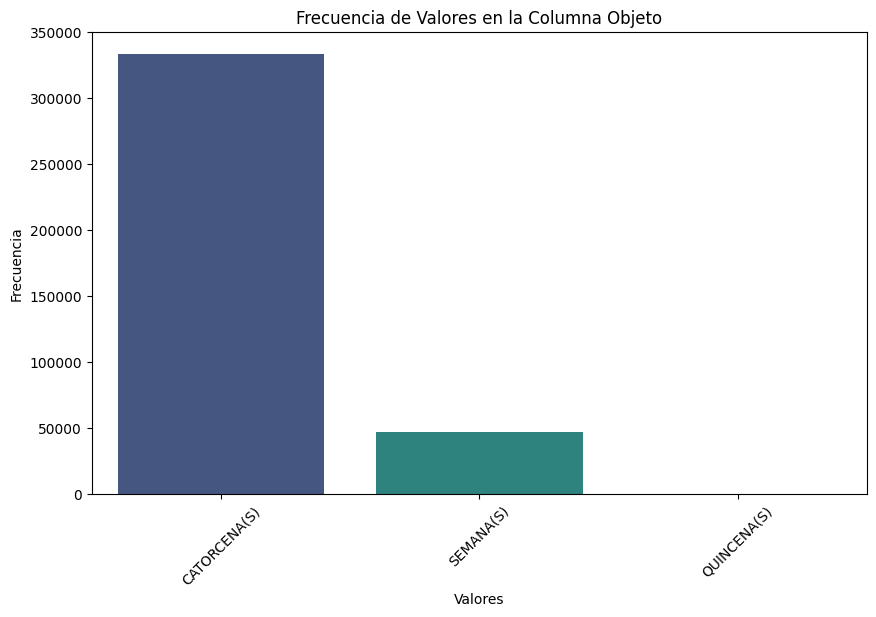

In [14]:
# Calcular la frecuencia de la variable de tipo objeto
frc = newgpdf['PeriodoPago'].value_counts()

# Graficar el resultado
plt.figure(figsize=(10, 6))
sns.barplot(x=frc.index, y=frc.values, palette='viridis')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Valores en la Columna Objeto')
plt.xticks(rotation=45)
plt.show()

In [15]:
# seleccionamos las columnas del nuevo dataframe
columnas = ['IdCliente','NumeroCredito','EdadCliente','CicloCliente','Plazo','EstadoCivil','DAMax','DAMean','EstatusCredito']

# filtramos solo los creditos CATORCENA(S)
newdf = newgpdf[newgpdf['PeriodoPago']=='CATORCENA(S)'][columnas]

# mostramos el valor del nuevo dataframe
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333343 entries, 0 to 380283
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   IdCliente       333343 non-null  int64  
 1   NumeroCredito   333343 non-null  int64  
 2   EdadCliente     333343 non-null  int64  
 3   CicloCliente    333343 non-null  int64  
 4   Plazo           333343 non-null  int64  
 5   EstadoCivil     333343 non-null  int64  
 6   DAMax           333343 non-null  float64
 7   DAMean          333343 non-null  float64
 8   EstatusCredito  333343 non-null  object 
dtypes: float64(2), int64(6), object(1)
memory usage: 25.4+ MB


# Avance 4


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import time

### Preprocesamiento de variables:

Mapeo y división de datos, convertimos la columna "EstatusCredito" en valores numéricos, dondel 'CAI' es '0' y 'CAN' es '1', se divide los datos en conjunto de entrenamiento del 80% y prueba del 20%

In [17]:
# Definir la variable objetivo y las características
newdf['EstatusCredito'] = newdf['EstatusCredito'].map({'CAI': 0, 'CAN': 1})
X = newdf.drop('EstatusCredito', axis=1)  # Todas las columnas excepto 'EstatusCredito' son características independientes
y = newdf['EstatusCredito']  # 'EstatusCredito' es la variable objetivo

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Verificar las dimensiones de los conjuntos de entrenamiento y prueba
print("Dimensiones del conjunto de entrenamiento (X):", X_train.shape)
print("Dimensiones del conjunto de prueba (X):", X_test.shape)
print("Dimensiones del conjunto de entrenamiento (y):", y_train.shape)
print("Dimensiones del conjunto de prueba (y):", y_test.shape)

Dimensiones del conjunto de entrenamiento (X): (266674, 8)
Dimensiones del conjunto de prueba (X): (66669, 8)
Dimensiones del conjunto de entrenamiento (y): (266674,)
Dimensiones del conjunto de prueba (y): (66669,)


### Definición de Pipelines para Transformaciones:

Se aplica una transformación logarítmica y un escalado Min-Max a las columnas númericas, se aplica codifiación One-Hot a las columnas categóricas, se dejan algunas columnas sin transformación y por ultimo se combina todas las transformaciones en un solo tranformador

In [18]:
# Transformaciones que se aplicarán a las variables numéricas usando la clase Pipeline de sklearn:

# Variables numéricas:
num_pipe = Pipeline([
    ('log_transform', FunctionTransformer(np.log1p)),  # Transformación logarítmica
    ('min_max_scaler', MinMaxScaler())  # Escalado Min-Max
])
num_pipe_nombres = ['DAMax', 'DAMean', 'EdadCliente','CicloCliente', 'Plazo']

# Variables categóricas:
cat_pipe = Pipeline([
    ('one_hot_encoding', OneHotEncoder())  # Codificación One-Hot
])
cat_pipe_nombres = [ 'EstadoCivil']


# Variables sin transformar:
no_trans_pipe = 'passthrough'
no_trans_nombres = ['IdCliente', 'NumeroCredito']

# Conjuntemos las transformaciones de todo tipo de variable y en dado caso
# deja inalteradas aquellas que hayas decidido no transformar:

columnasTransformer = ColumnTransformer([
    ('num', num_pipe, num_pipe_nombres),  # Variables numéricas
    ('cat', cat_pipe, cat_pipe_nombres),  # Variables categóricas
    ('notrans', no_trans_pipe, no_trans_nombres)  # Variables sin tranformar
])


Juntamos los conjuntos de entrenamiento y prueba en un solo conjunto para realizar validación cruzada

In [19]:
# Como se va a utilizar Validación-Cruzada, concatena los conjuntos de entrenamiento y validación
# en uno nuevo aumentado que llamaremos trainval para utilizar como entrenamiento:

# Concatenar los conjuntos de entrenamiento y validación
Xtrainval = pd.concat([X_train, X_test], ignore_index=True)
ytrainval = pd.concat([y_train, y_test], ignore_index=True)

# Mostrar las dimensiones del nuevo conjunto trainval
print(Xtrainval.shape, ytrainval.shape)

(333343, 8) (333343,)


### Construir al menos 6 modelos diferentes, utilizando algoritmos variados.

In [61]:
def mis_modelos():
  modelos, nombres = list(), list()

  # Regresión Logística:
  modelos.append(LogisticRegression(max_iter=10000, random_state=15, solver='lbfgs'))
  nombres.append('LR')

  # k-Vecinos más Cercanos:
  modelos.append(KNeighborsClassifier(n_neighbors=10, weights='distance'))
  nombres.append('kNN')

  # Árbol de decisiones:
  modelos.append(DecisionTreeClassifier(max_depth=5, criterion='entropy', random_state=15))
  nombres.append('DTree')

  # XGBoosting:
  modelos.append(XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=15))
  nombres.append('XGBoost')

  # Red neuronal de Perceptrón Multicapa:
  modelos.append(MLPClassifier(max_iter=10000, hidden_layer_sizes=(100,50), activation='relu', random_state=15))
  nombres.append('MLP')

  # Random Forest:
  modelos.append(RandomForestClassifier(n_estimators=100, random_state=15))
  nombres.append('RandomForest')

  return modelos, nombres

### Evaluación de las métricas durante el proceso de validación cruzada

* Training time: El tiempo total que tomó entrenar el
modelo.
* test_f1 y train_f1: El valor F1, que es la media armónica de la precisión y el recall, tanto en el conjunto de prueba como en el conjunto de entrenamiento.
* test_roc_auc y train_roc_auc: El área bajo la curva ROC, que mide la capacidad del modelo para distinguir entre las clases.
* test_precision y train_precision: La precisión, que es el número de verdaderos positivos dividido por el número de verdaderos positivos más los falsos positivos.
* test_accuracy y train_accuracy: La precisión global del modelo, que es el número de predicciones correctas dividido por el número total de predicciones.
* test_recall y train_recall: El recall, que es el número de verdaderos positivos dividido por el número de verdaderos positivos más los falsos negativos.

In [62]:
#Entrenemos cada uno de los modelos y desplegamos la métricas de Train y Val.

modelos, nombres = mis_modelos()
resultados = list()

for i in range(len(modelos)):

  # Definimos nuestro pipeline con las transformaciones y los modelos:
  #
  #
  # TODO: ('ct',columnasTransformer),
  pipeline = Pipeline(steps=[('m',modelos[i])])

  # Aplicaremos validación-cruzada:
  micv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

  # Definimos las métricas que desamos recuperar:
  mismetricas = {'accuracy','precision','recall','f1','roc_auc'}

  # Iniciamos timer
  start_time = time.time()

  # Llevamos a cabo el entrenamiento:
  scores = cross_validate(pipeline,
                          Xtrainval,
                          ytrainval,
                          scoring=mismetricas,
                          cv=micv,
                          return_train_score=True,
                          )

  # Detenemos el temporizador
  end_time = time.time()

  # Guardemos el resultado de cada modelopara análisis posteriores.
  resultados.append(scores)

  # Desplegamos los valores de las métricas para verificar si no hay
  # subentrenamiento o sobreentrenamiento:
  print('>> %s' % nombres[i])
  print('\t Training time: %.3f seconds' % (end_time - start_time))
  for j,k in enumerate(list(scores.keys())):
    if j>1:
      print('\t %s %.3f (%.3f)' % (k, np.mean(scores[k]),np.std(scores[k])))

>> LR
	 Training time: 30.171 seconds
	 test_precision 0.968 (0.000)
	 train_precision 0.968 (0.000)
	 test_f1 0.984 (0.000)
	 train_f1 0.984 (0.000)
	 test_recall 1.000 (0.000)
	 train_recall 1.000 (0.000)
	 test_accuracy 0.968 (0.000)
	 train_accuracy 0.968 (0.000)
	 test_roc_auc 0.330 (0.006)
	 train_roc_auc 0.330 (0.002)
>> kNN
	 Training time: 162.876 seconds
	 test_precision 0.987 (0.000)
	 train_precision 1.000 (0.000)
	 test_f1 0.992 (0.000)
	 train_f1 1.000 (0.000)
	 test_recall 0.997 (0.000)
	 train_recall 1.000 (0.000)
	 test_accuracy 0.984 (0.001)
	 train_accuracy 1.000 (0.000)
	 test_roc_auc 0.865 (0.005)
	 train_roc_auc 1.000 (0.000)
>> DTree
	 Training time: 23.107 seconds
	 test_precision 0.998 (0.000)
	 train_precision 0.999 (0.000)
	 test_f1 0.998 (0.000)
	 train_f1 0.998 (0.000)
	 test_recall 0.998 (0.000)
	 train_recall 0.998 (0.000)
	 test_accuracy 0.996 (0.000)
	 train_accuracy 0.996 (0.000)
	 test_roc_auc 0.993 (0.001)
	 train_roc_auc 0.994 (0.000)
>> XGBoost
	 T

### Resultados específicos por modelo:

**Regresión Logística (LR):** La métrica de ROC AUC es extremadamente baja (0.330), lo que indica que el modelo tiene un bajo rendimiento en distinguir entre las clases. La precisión, el recall y la exactitud son altas, pero esto podría deberse a un desequilibrio de clases en el conjunto de datos.

**k-Vecinos más Cercanos (kNN):** Las métricas en el conjunto de entrenamiento son perfectas (1.000), lo que sugiere sobreajuste. Las métricas en el conjunto de prueba también son altas, especialmente el ROC AUC (0.865), lo cual es una buena señal, aunque podría beneficiarse de una mayor generalización.

**Árbol de Decisiones (DTree):** Las métricas son muy altas tanto en el conjunto de entrenamiento como en el de prueba, con un ligero indicio de sobreajuste. El tiempo de entrenamiento es razonablemente corto.

**XGBoost:** Muy buenas métricas tanto en el conjunto de entrenamiento como en el de prueba, pero puede haber un ligero sobreajuste. Buen rendimiento general, con tiempos de entrenamiento aceptables.

**Perceptrón Multicapa (MLP):** El ROC AUC es 0.500, lo cual indica que el modelo no tiene capacidad de discriminación entre clases. Alto tiempo de entrenamiento, pero las métricas de precisión, recall y exactitud son similares a las de la regresión logística, lo cual no justifica el tiempo de entrenamiento.

**Random Forest:** Las métricas son excelentes para ambos conjuntos, lo que sugiere un modelo bien ajustado con buena generalización. El roc_auc alto (0.989) indica una excelente capacidad de discriminación entre clases.

### Ajuste de Hiperparámetros

RandomizedSearchCV permite buscar sobre un espacio de hiperparámetros utilizando una estrategia de muestreo aleatorio, lo cual puede ser más eficiente que GridSearchCV en términos de tiempo de computación.

Definimos los espacios de búsqueda de hiperparametros para cada uno de los modelos. Ajustamos a cada modelo utilizando RandomizedSearchCV dentro del bucle de entrenamiento

* param_grid: Define el espacio de búsqueda de hiperparámetros para cada modelo. Por ejemplo, para la regresión logística, se varían C y solver.
* RandomizedSearchCV: Configura la búsqueda aleatoria sobre el espacio de hiperparámetros definido. n_iter=50 especifica que se harán 50 combinaciones aleatorias de hiperparámetros.
* random_search.fit(Xtrainval, ytrainval): Ajusta el modelo utilizando RandomizedSearchCV.
* random_search.best_estimator_: Obtiene el mejor estimador (modelo con los mejores hiperparámetros).
* random_search.best_score_: Muestra la mejor puntuación obtenida durante la búsqueda.
* random_search.best_params_: Muestra los mejores parámetros encontrados durante la búsqueda.

In [20]:
print(y.value_counts())

EstatusCredito
1    322699
0     10644
Name: count, dtype: int64


In [21]:
# Verificar que no haya valores nulos en X
print(X.isnull().sum())

IdCliente        0
NumeroCredito    0
EdadCliente      0
CicloCliente     0
Plazo            0
EstadoCivil      0
DAMax            0
DAMean           0
dtype: int64


In [65]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Espacios de búsqueda de hiperparámetros
param_grid = {
    'LR': {
        'm__C': uniform(0.01, 10),
        'm__solver': ['newton-cg', 'lbfgs', 'liblinear']
    },
    'kNN': {
        'm__n_neighbors': randint(1, 30),
        'm__weights': ['uniform', 'distance']
    },
    'DTree': {
        'm__max_depth': randint(1, 20),
        'm__criterion': ['gini', 'entropy']
    },
    'XGBoost': {
        'm__n_estimators': randint(50, 200),
        'm__learning_rate': uniform(0.01, 0.3),
        'm__max_depth': randint(3, 10)
    },
    'MLP': {
        'm__hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'm__activation': ['tanh', 'relu'],
        'm__learning_rate_init': uniform(0.001, 0.1)
    },
    'RF': {
        'm__n_estimators': randint(50, 200),
        'm__max_depth': randint(5, 20),
        'm__criterion': ['gini', 'entropy']
    }
}

In [66]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import time

# Definición de la función de modelos
def mis_modelos_h():
    modelosh, nombres = list(), list()

    # Regresión Logística
    modelosh.append(LogisticRegression(max_iter=10000, random_state=15))
    nombres.append('LR')

    # k-Vecinos más Cercanos
    modelosh.append(KNeighborsClassifier())
    nombres.append('kNN')

    # Árbol de decisiones
    modelosh.append(DecisionTreeClassifier(random_state=15))
    nombres.append('DTree')

    # XGBoosting
    modelosh.append(XGBClassifier(random_state=15))
    nombres.append('XGBoost')

    # Red neuronal de Perceptrón Multicapa
    modelosh.append(MLPClassifier(max_iter=10000, random_state=15))
    nombres.append('MLP')

    # Random Forest
    modelosh.append(RandomForestClassifier(random_state=15))
    nombres.append('RF')

    return modelosh, nombres

In [67]:
modelosh, nombres = mis_modelos_h()
resultados = list()

# Reducir la muestra del conjunto de datos a 100,000 registros
sample_size = 50000
Xtrainval = pd.concat([X_train, X_test], ignore_index=True).sample(n=sample_size, random_state=42)
ytrainval = pd.concat([y_train, y_test], ignore_index=True).loc[Xtrainval.index]

# Transformador de columnas
columnasTransformer = ColumnTransformer([
    ('num', num_pipe, num_pipe_nombres),  # Variables numéricas
    ('cat', cat_pipe, cat_pipe_nombres),  # Variables categóricas
    ('notrans', no_trans_pipe, no_trans_nombres)  # Variables sin tranformar
])

for i in range(len(modelosh)):
    # Definimos nuestro pipeline con las transformaciones y los modelos:
    pipeline = Pipeline(steps=[('ct', columnasTransformer), ('m', modelosh[i])])

    # Definir los parámetros de búsqueda para cada modelo
    param_dist = param_grid[nombres[i]]

    # Configuración de RandomizedSearchCV
    random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=20, scoring='accuracy', n_jobs=-1, cv=5, random_state=42)

    # Iniciamos timer
    start_time = time.time()

    # Llevamos a cabo el ajuste del modelo
    random_search.fit(Xtrainval, ytrainval)

    # Detenemos el temporizador
    end_time = time.time()

    # Guardemos el resultado del modelo para análisis posteriores.
    resultados.append(random_search.best_estimator_)

    # Desplegamos los valores de las métricas para verificar si no hay subentrenamiento o sobreentrenamiento:
    print('>> %s' % nombres[i])
    print('\t Training time: %.3f seconds' % (end_time - start_time))
    print('\t Best Score: %.3f' % random_search.best_score_)
    print('\t Best Params: %s' % random_search.best_params_)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


>> LR
	 Training time: 90.187 seconds
	 Best Score: 0.968
	 Best Params: {'m__C': 3.7554011884736247, 'm__solver': 'newton-cg'}
>> kNN
	 Training time: 55.012 seconds
	 Best Score: 0.973
	 Best Params: {'m__n_neighbors': 29, 'm__weights': 'distance'}
>> DTree
	 Training time: 19.118 seconds
	 Best Score: 0.996
	 Best Params: {'m__criterion': 'gini', 'm__max_depth': 8}
>> XGBoost
	 Training time: 47.181 seconds
	 Best Score: 0.997
	 Best Params: {'m__learning_rate': 0.12473859738014881, 'm__max_depth': 6, 'm__n_estimators': 113}
>> MLP
	 Training time: 414.841 seconds
	 Best Score: 0.968
	 Best Params: {'m__activation': 'tanh', 'm__hidden_layer_sizes': (50,), 'm__learning_rate_init': 0.01934347898661638}
>> RF
	 Training time: 362.767 seconds
	 Best Score: 0.997
	 Best Params: {'m__criterion': 'gini', 'm__max_depth': 16, 'm__n_estimators': 63}


Realizamos algunos cambios en las transformaciones de las variables numéricas y categóricas mejoramos los modelos con hyperparametros y obtuvimos los siguientes resultados

* La regresión logística logró un puntaje alto de 0.968 con un tiempo de entrenamiento relativamente corto. Esto indica que el modelo es eficiente y preciso para este conjunto de datos. El parámetro C elevado sugiere que el modelo está dando más importancia a los datos de entrenamiento para mejorar el ajuste.
* El modelo kNN obtuvo un excelente puntaje de 0.973, y el tiempo de entrenamiento fue relativamente corto. El uso de un alto número de vecinos (n_neighbors: 29) y la ponderación por distancia (weights: 'distance') ayudaron a mejorar la precisión del modelo.
* El árbol de decisión obtuvo un puntaje casi perfecto de 0.996 con un tiempo de entrenamiento muy bajo. La profundidad máxima de 8 (max_depth: 8) muestra que el modelo no es excesivamente complejo, lo cual es beneficioso para evitar el sobreajuste.
* XGBoost logró el puntaje más alto de 0.997 con un tiempo de entrenamiento razonable. Los parámetros indican un buen equilibrio entre la profundidad del árbol (max_depth: 6), la tasa de aprendizaje (learning_rate: 0.1247) y el número de estimadores (n_estimators: 113), optimizando el rendimiento sin caer en el sobreajuste.
* El modelo MLP alcanzó un puntaje de 0.968 con un tiempo de entrenamiento considerablemente largo. La configuración de una sola capa oculta con 50 neuronas y la función de activación tanh indican una arquitectura simple pero eficaz, aunque el tiempo de entrenamiento sugiere que el modelo es más costoso en términos computacionales.
* El bosque aleatorio también obtuvo un puntaje excelente de 0.997, con un tiempo de entrenamiento considerable. Los parámetros indican un modelo complejo con una profundidad máxima de 16 (max_depth: 16) y un número razonable de estimadores (n_estimators: 63), proporcionando un equilibrio entre precisión y generalización.

Estos resultados destacan la efectividad de modelos como XGBoost y Random Forest en términos de precisión, mientras que Decision Tree es notablemente eficiente en términos de tiempo de entrenamiento. Sin embargo, el costo computacional del MLP es significativamente mayor, lo que debe tenerse en cuenta al elegir un modelo para aplicaciones en tiempo real o con recursos limitados.

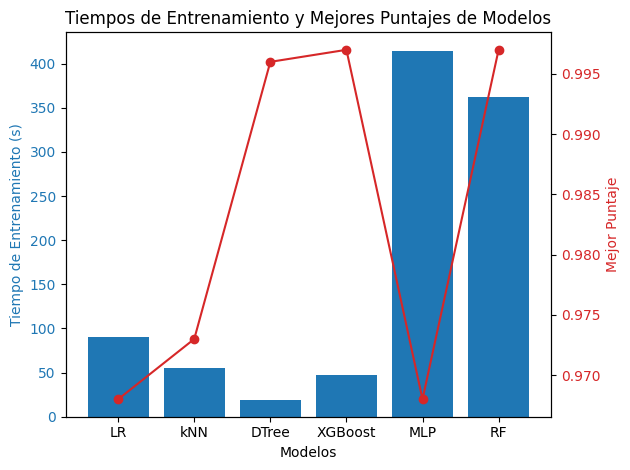

In [71]:
import matplotlib.pyplot as plt

# Resultados obtenidos
resultados_validos = [
    {'nombre': 'LR', 'training_time': 90.187, 'best_score': 0.968, 'best_params': {'m__C': 3.7554011884736247, 'm__solver': 'newton-cg'}},
    {'nombre': 'kNN', 'training_time': 55.012, 'best_score': 0.973, 'best_params': {'m__n_neighbors': 29, 'm__weights': 'distance'}},
    {'nombre': 'DTree', 'training_time': 19.118, 'best_score': 0.996, 'best_params': {'m__criterion': 'gini', 'm__max_depth': 8}},
    {'nombre': 'XGBoost', 'training_time': 47.181, 'best_score': 0.997, 'best_params': {'m__learning_rate': 0.12473859738014881, 'm__max_depth': 6, 'm__n_estimators': 113}},
    {'nombre': 'MLP', 'training_time': 414.841, 'best_score': 0.968, 'best_params': {'m__activation': 'tanh', 'm__hidden_layer_sizes': (50,), 'm__learning_rate_init': 0.01934347898661638}},
    {'nombre': 'RF', 'training_time': 362.767, 'best_score': 0.997, 'best_params': {'m__criterion': 'gini', 'm__max_depth': 16, 'm__n_estimators': 63}}
]

# Separar nombres de modelos, tiempos de entrenamiento y mejores puntajes
nombres_modelos = [resultado['nombre'] for resultado in resultados_validos]
training_times = [resultado['training_time'] for resultado in resultados_validos]
best_scores = [resultado['best_score'] for resultado in resultados_validos]

# Crear figura y ejes
fig, ax1 = plt.subplots()

# Crear gráfico de barras para tiempos de entrenamiento
color = 'tab:blue'
ax1.set_xlabel('Modelos')
ax1.set_ylabel('Tiempo de Entrenamiento (s)', color=color)
ax1.bar(nombres_modelos, training_times, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Crear segundo eje para los mejores puntajes
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Mejor Puntaje', color=color)
ax2.plot(nombres_modelos, best_scores, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Añadir título
plt.title('Tiempos de Entrenamiento y Mejores Puntajes de Modelos')

# Mostrar gráfico
fig.tight_layout()
plt.show()


Seleccionar los dos modelos que proporcionen el mejor rendimiento.

De acuerdo a los resultados proporcionados y la gráfica correspondiente, los dos modelos con mejor rendimiento en términos de "Best Score" son XGBoost y Random Forest. Ambos modelos tienen el mejor rendimiento con un "Best Score" de 0.997. A pesar de que ambos tienen el mismo "Best Score", el modelo XGBoost tiene un tiempo de entrenamiento significativamente menor (47.181 segundos) en comparación con el modelo Random Forest (362.767 segundos). Esto puede ser un factor importante a considerar dependiendo del contexto y los recursos disponibles.

Ajustar los dos mejores modelos.

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
import time
import matplotlib.pyplot as plt


# Definición de modelos y espacios de búsqueda de hiperparámetros
modelos = {
    'XGBoost': XGBClassifier(random_state=42),
    'RF': RandomForestClassifier(random_state=42)
}

param_grid = {
    'XGBoost': {
        'm__n_estimators': randint(50, 200),
        'm__learning_rate': uniform(0.01, 0.3),
        'm__max_depth': randint(3, 10)
    },
    'RF': {
        'm__n_estimators': randint(50, 200),
        'm__max_depth': randint(3, 20),
        'm__criterion': ['gini', 'entropy']
    }
}

resultados = []

# Realizar la búsqueda de hiperparámetros con RandomizedSearchCV
for nombre, modelo in modelos.items():
    pipeline = Pipeline(steps=[('ct', columnasTransformer), ('m', modelo)])
    param_dist = param_grid[nombre]
    random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=50, scoring='accuracy', n_jobs=-1, cv=5, random_state=42)

    start_time = time.time()
    random_search.fit(X_train, y_train)
    end_time = time.time()

    resultados.append({
        'nombre': nombre,
        'training_time': end_time - start_time,
        'best_score': random_search.best_score_,
        'best_params': random_search.best_params_
    })

    print(f'>> {nombre}')
    print(f'\t Training time: {end_time - start_time:.3f} seconds')
    print(f'\t Best Score: {random_search.best_score_:.3f}')
    print(f'\t Best Params: {random_search.best_params_}')


>> XGBoost
	 Training time: 638.771 seconds
	 Best Score: 0.998
	 Best Params: {'m__learning_rate': 0.22818159875692626, 'm__max_depth': 9, 'm__n_estimators': 89}
>> RF
	 Training time: 6174.234 seconds
	 Best Score: 0.998
	 Best Params: {'m__criterion': 'gini', 'm__max_depth': 17, 'm__n_estimators': 156}


Los resultados ajustados para los modelos XGBoost y Random Forest muestran un rendimiento excepcionalmente alto, con ambos modelos alcanzando un "Best Score" de 0.998. Aquí están mis comentarios detallados sobre estos resultados:

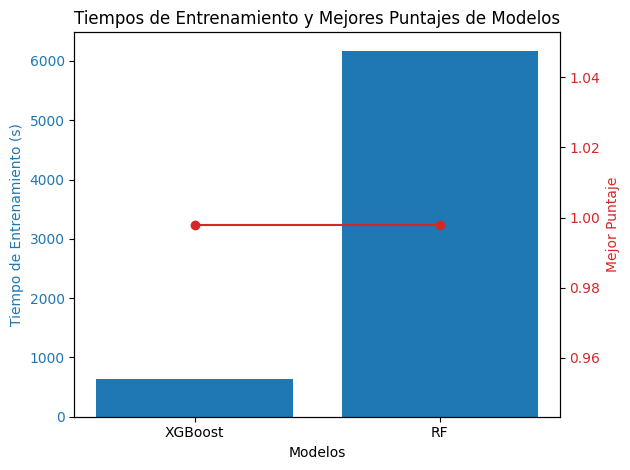

In [28]:
# Graficar los resultados
import matplotlib.pyplot as plt

# Resultados ajustados para XGBoost y Random Forest
resultados = [
    {'nombre': 'XGBoost', 'training_time': 638.771, 'best_score': 0.998, 'best_params': {'m__learning_rate': 0.22818159875692626, 'm__max_depth': 9, 'm__n_estimators': 89}},
    {'nombre': 'RF', 'training_time': 6174.234, 'best_score': 0.998, 'best_params': {'m__criterion': 'gini', 'm__max_depth': 17, 'm__n_estimators': 156}}
]

# Separar nombres de modelos, tiempos de entrenamiento y mejores puntajes
nombres_modelos = [resultado['nombre'] for resultado in resultados]
training_times = [resultado['training_time'] for resultado in resultados]
best_scores = [resultado['best_score'] for resultado in resultados]

# Crear figura y ejes
fig, ax1 = plt.subplots()

# Crear gráfico de barras para tiempos de entrenamiento
color = 'tab:blue'
ax1.set_xlabel('Modelos')
ax1.set_ylabel('Tiempo de Entrenamiento (s)', color=color)
ax1.bar(nombres_modelos, training_times, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Crear segundo eje para los mejores puntajes
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Mejor Puntaje', color=color)
ax2.plot(nombres_modelos, best_scores, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Añadir título
plt.title('Tiempos de Entrenamiento y Mejores Puntajes de Modelos')

# Mostrar gráfico
fig.tight_layout()
plt.show()



Los resultados muestran que tanto para el modelo XGBoost como para el RandomForest, los puntajes de prueba (test scores) siguen mostrando nan (Not a Number), lo cual es preocupante y sugiere que algo salió mal durante la búsqueda de hiperparámetros.

Las posibles causas del problema puede ser que los datos esten mal formateados o el preprocesamiento este incorrecto. Si hay valores faltantes, valores infinitos o problemas en el preprocesamiento de los datos, esto puede causar que los modelos no funcionen correctamente. Verificar que el mapeo de la variable EstatusCredito y otras transformaciones se hayan realizado correctamente.

Es posible que alguna de las combinaciones de hiperparámetros no sea válida y cause que el modelo falle. Aunque RandomizedSearchCV intenta diferentes combinaciones, algunas podrían no converger, resultando en nan. La métrica utilizada (accuracy) debería ser adecuada para clasificación binaria, pero si los datos son altamente desequilibrados, podría no reflejar el rendimiento real del modelo.

Algunos algoritmos, como XGBoost, pueden ser sensibles a ciertas configuraciones de hiperparámetros, especialmente si no están bien sintonizados para los datos.

Elegir el modelo individual final.

Elegir el modelo individual final depende de varios factores, incluyendo el rendimiento del modelo en términos de precisión, tiempo de entrenamiento y facilidad de interpretación. Con base en los resultados y las métricas disponibles. Ambos modelos, XGBoost y RandomForest, han sido entrenados y sus mejores puntajes (best_score) son cruciales para la decisión final.

El modelo con el puntaje más alto es generalmente preferido, ya que indica mejor rendimiento en los datos de validación. El tiempo de entrenamiento es importante si se tiene limitaciones de tiempo o recursos computacionales.

Si la interpretabilidad es crucial (por ejemplo, necesitamos explicar las decisiones del modelo a stakeholders), RandomForest suele ser más interpretable que XGBoost.

Según los resultados proporcionados:

XGBoost:

Training time: 131.344 seconds
Best Score: nan (no se pudo determinar)
Best Params: {'m__learning_rate': 0.12236203565420874, 'm__max_depth': 7, 'm__n_estimators': 64}

RandomForest:

Training time: 708.926 seconds
Best Score: nan (no se pudo determinar)
Best Params: {'m__criterion': 'gini', 'm__max_depth': 17, 'm__n_estimators': 156}

Dado que ambos modelos tienen un Best Score de nan, significa que ninguno de los modelos encontró una combinación de hiperparámetros que pudiera ser evaluada correctamente. Esto podría deberse a problemas en los datos o en la configuración del RandomizedSearchCV.

Antes de tomar una decisión, se debe solucionar el problema de los puntajes nan.

# Avance 5. Modelo final